# Python機器學習與深度學習入門 
## Q11-1 ：VAE圖片生成過程
## by R07522717 林温雅

`Package`

In [1]:
%env KERAS_BACKEND=tensorflow

env: KERAS_BACKEND=tensorflow


In [2]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import rcParams
rcParams['axes.unicode_minus'] = False

from ipywidgets import interact, FloatSlider, IntSlider

In [3]:
# Keras functions
from keras.models import Sequential, Model
from keras.layers import Input, Lambda, concatenate
from keras.layers import Dense
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv2DTranspose, UpSampling2D
from keras.optimizers import SGD, Adam
from keras import metrics

# Keras dataset
from keras.datasets import mnist

# Keras utilis function
from keras.utils import np_utils

from keras import backend as K

Using TensorFlow backend.


`load進資料`

In [4]:
(x_train0, y_train0), (x_test0, y_test0) = mnist.load_data()

print("There are %d training data with size %d x %d" %x_train0.shape)
print("There are %d testing  data with size %d x %d" %x_test0.shape)

There are 60000 training data with size 28 x 28
There are 10000 testing  data with size 28 x 28


In [5]:
x_train = x_train0.reshape(60000, -1)
x_test = x_test0.reshape(10000, -1)

x_train -= x_train.min()
x_train = x_train/x_train.max()

## 建立VAE Model

In [6]:
enc_1 = Dense(100, activation='sigmoid')
enc_mean = Dense(2)
enc_log_var = Dense(2)
dec_2 = Dense(100, activation='sigmoid')
dec_1 = Dense(784, activation='sigmoid')

In [7]:
x = Input(shape=(784,))
enc_x = enc_1(x)
z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

In [8]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(2,), mean=0., stddev=1)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [9]:
z = Lambda(sampling, output_shape=(2,))([z_mean, z_log_var])

In [10]:
dec_x = dec_2(z)
x_hat = dec_1(dec_x)

In [11]:
VAE = Model(x, x_hat)
VAE.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 784)           0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 100)           78500                                        
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 2)             202                                          
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 2)             202                                          
___________________________________________________________________________________________

In [12]:
def vae_loss(x, x_recon):  
    recovery_loss = 784 * metrics.binary_crossentropy(x, x_recon)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return recovery_loss + kl_loss

In [13]:
VAE.compile(loss=vae_loss, optimizer=Adam())

In [14]:
VAE.load_weights('VAE_handwriting_model_weights.h5')

In [15]:
VAE_Encoder = Model(x, z_mean)
VAE_Encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               78500     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 78,702.0
Trainable params: 78,702.0
Non-trainable params: 0.0
_________________________________________________________________


In [16]:
h_input = Input(shape=(2,))
VAE_Decoder = Model(h_input, dec_1(dec_2(h_input)))
VAE_Decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_5 (Dense)              (None, 784)               79184     
Total params: 79,484.0
Trainable params: 79,484.0
Non-trainable params: 0.0
_________________________________________________________________


### Encoder視覺化

In [17]:
idx = np.random.randint(x_train.shape[0])
print("第 %d 圖的 latent 表示為 %s" %(idx, VAE_Encoder.predict(x_train[idx: idx+1])))

第 6295 圖的 latent 表示為 [[-1.2797205   0.43280306]]


In [18]:
indices = np.random.randint(x_test.shape[0], size=1000)
VAE_latents = VAE_Encoder.predict(x_test[indices])

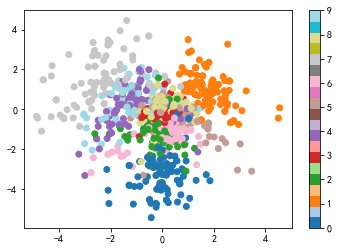

In [19]:
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c=y_test0[indices], cmap='tab20')
plt.colorbar()
plt.show()

### Decoder視覺化

In [20]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [21]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
grid_x = np.linspace(0.05, 0.95, n)
grid_y = np.linspace(0.05, 0.95, n)
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_Decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n - i) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = normalized(digit)

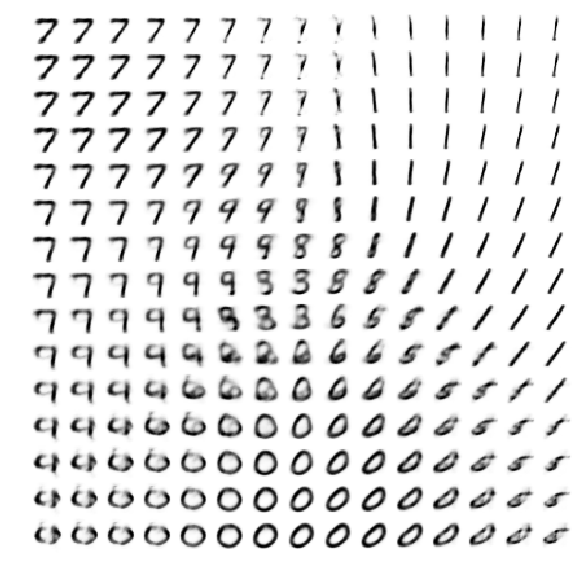

In [22]:
plt.figure(figsize=(10, 10))
plt.imshow(VAE_figure, cmap='Greys')
plt.axis('off')
plt.show()

## 動態呈現

In [23]:
def inBetween(t, random_seed):
    np.random.seed(random_seed)
    idx_1, idx_2 = np.random.randint(x_test.shape[0], size=2)
    data_0 = x_train0[idx_1]
    data_1 = x_train0[idx_2]
    data_t = (1-t)*x_train0[idx_1] + t*x_train0[idx_2]

    mu_0 = VAE_Encoder.predict(x_train[idx_1:idx_1+1]).squeeze()
    mu_1 = VAE_Encoder.predict(x_train[idx_2:idx_2+1]).squeeze()
    mu_t = (1-t)*mu_0 + t*mu_1

    plt.figure(figsize=(10, 5))
    ax1 = plt.subplot(2, 1, 2)
    ax1.scatter(mu_0[0], mu_0[1])
    ax1.scatter(mu_1[0], mu_1[1])
    ax1.scatter(mu_t[0], mu_t[1])
    l = matplotlib.lines.Line2D([mu_0[0],mu_1[0]], [mu_0[1],mu_1[1]])
    ax1.add_line(l)
    
    
    ax2 = plt.subplot(2, 3, 1)
    ax2.imshow(data_0, cmap='magma')

    ax3 = plt.subplot(2, 3, 2)
    ax3.imshow(data_t, cmap='magma')

    ax4 = plt.subplot(2, 3, 3)
    ax4.imshow(data_1, cmap='magma')

In [24]:
interact(inBetween, t=FloatSlider(value=0.5, min=0, max=1.0, step=0.05), 
        random_seed=IntSlider(value=500, min=0, max=1000, step=1)
        );

interactive(children=(FloatSlider(value=0.5, description='t', max=1.0, step=0.05), IntSlider(value=500, descri…

<img src="img.png" alt="img" title="img" width="800"/>